In [1]:
# Provides ways to work with large multidimensional arrays
import numpy as np 
# Allows for further data manipulation and analysis
import pandas as pd
from pandas_datareader import data # Reads stock data 
import matplotlib.pyplot as plt # Plotting
import matplotlib.dates as mdates # Styling dates
%matplotlib inline

import datetime as dt # For defining dates
# import mplfinance as mpf # Matplotlib finance

import time

# Used to get data from a directory
import os
from os import listdir
from os.path import isfile, join

#Statsmodels is a great library we can use to run regressions.
import statsmodels.api as sm
# Seaborn extends the capabilities of Matplotlib
import seaborn as sns
# Used for calculating regressions
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [2]:
#change the tickers here according to what's in the portfolio
tickers = ['LHX','ODFL','SAIA','AXP','TROW','CG','CSWC','CBRE','SBAC','EPAM','QCOM','ASML','DSGX',
          'MGIC','RDWR','CTLT','BRKR','ICLR','MODV','^FVX']

start_date = '2017-01-01'
end_date = '2022-01-01'

panel_data = data.DataReader(tickers,'yahoo', start_date, end_date)

In [56]:
#check that all stocks have the same amount of data otherwise change the date range

adj_close = panel_data['Adj Close']
adj_close.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2017-01-03 to 2021-12-31
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   LHX     1259 non-null   float64
 1   ODFL    1259 non-null   float64
 2   SAIA    1259 non-null   float64
 3   AXP     1259 non-null   float64
 4   TROW    1259 non-null   float64
 5   CG      1259 non-null   float64
 6   CSWC    1259 non-null   float64
 7   CBRE    1259 non-null   float64
 8   SBAC    1259 non-null   float64
 9   EPAM    1259 non-null   float64
 10  QCOM    1259 non-null   float64
 11  ASML    1259 non-null   float64
 12  DSGX    1259 non-null   float64
 13  MGIC    1259 non-null   float64
 14  RDWR    1259 non-null   float64
 15  CTLT    1259 non-null   float64
 16  BRKR    1259 non-null   float64
 17  ICLR    1259 non-null   float64
 18  MODV    1259 non-null   float64
 19  ^FVX    1259 non-null   float64
dtypes: float64(20)
memory usage: 206.6 KB


## Function that saves dataframe to CSV

In [57]:
def save_dataframe_to_csv(kind, df, ticker):
    df.to_csv(kind + ticker + '.csv')

In [58]:
# for ticker in tickers:
#     panel_data = data.DataReader(ticker,'yahoo', start_date, end_date)
# #     close = panel_data['Close']
#     adj_close = panel_data['Adj Close']
#     save_dataframe_to_csv('adj_close', adj_close, ticker)

## Function that returns dataframe from a CSV

In [59]:
def get_df_from_csv(kind, ticker):
    try:
        df = pd.read_csv(kind + ticker + '.csv', index_col='Date', 
                         parse_dates=True)
    except FileNotFoundError:
        pass
        # print("File Doesn't Exist")
    else:
        return df

## Add Daily Return to dataframe

In [60]:
def add_daily_return_to_df(kind, df, ticker):
    df['daily_return'] = (df['Adj Close'] / df['Adj Close'].shift(1)) - 1
    # Save data to a CSV file
    save_dataframe_to_csv(kind, df, ticker)
    return df

In [61]:
for ticker in tickers:
    df = get_df_from_csv('adj_close', ticker)
    add_daily_return_to_df('adj_close', df, ticker)

## Merge multiple stocks in one dataframe by col name

In [62]:
def merge_df_by_column_name(col_name, sdate, edate, *tickers):
    # Will hold data for all dataframes with the same column name
    mult_df = pd.DataFrame()
    
    for x in tickers:
        df = get_df_from_csv('adj_close', x)
        
        # NEW Check if your dataframe has duplicate indexes
        if not df.index.is_unique:
            # Delete duplicates 
            df = df.loc[~df.index.duplicated(), :]
        
        mask = (df.index >= sdate) & (df.index <= edate)
        mult_df[x] = df.loc[mask][col_name]
        
    return mult_df

## Get stock prices on date

In [63]:
def get_prices_on_date(stocks_df, date):
    return stocks_df.loc[pd.DatetimeIndex([date])]['Adj Close'].item()

## Returns the value of portfolio by date

In [64]:
def get_port_val_by_date(date, shares, tickers):
    port_prices = merge_df_by_column_name('Adj Close',  date, date, *port_list)
    # Convert from dataframe to Python list
    port_prices = port_prices.values.tolist()
    # Trick that converts a list of lists into a single list
    port_prices = sum(port_prices, [])
    
    # Create a list of values by multiplying shares by price
    value_list = []
    for price, share in zip(port_prices, shares):
        value_list.append(price * share)
    
    return sum(value_list)

## Find Daily Return for Whole Portfolio

In [65]:
def get_port_daily_return(sdate, edate, shares, tickers):
    # Merge all daily prices for all stocks into 1 dataframe
    mult_df = merge_df_by_column_name('Adj Close',  sdate, 
                                  edate, *port_list)
    
    # Get the number of stocks in portfolio
    num_cols = len(mult_df.columns)
    
    # Multiply each stock column by the number of shares
    i = 0
    while i < num_cols:
        mult_df[tickers[i]] = mult_df[tickers[i]].apply(lambda x: x * shares[i])
        i += 1
        
    # Create a new column with the sums of all stocks named Total
    mult_df['Total'] = mult_df.iloc[:, 0:num_cols].sum(axis=1)
    
    # Add column for portfolio daily return
    mult_df['daily_return'] = (mult_df['Total'] / mult_df['Total'].shift(1)) - 1
    
    return mult_df

In [66]:
#change to the list of stocks we using
port_list = ['LHX','ODFL','SAIA','AXP','TROW','CG','CSWC','CBRE','SBAC','EPAM','QCOM','ASML','DSGX',
          'MGIC','RDWR','CTLT','BRKR','ICLR','MODV']

#add in the weightage of stocks
port_shares = [0.0096774,0.045642,0.0046806,0.0007318,0.0054878,0.0079948,0.0057856,0.028368,0.061632,
               0.0030595,8.10E-06,0.0034595,0.0020299,0.0009189,0.0005241,0.0058504,0.004437,0.0067168,
               0.0029958]

# tot_port_df = get_port_daily_return('2020-01-02', '2020-12-31', 
#                                     port_shares, port_list)

#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2022-01-01', port_shares, port_list)
tot_port_df

,LHX,ODFL,SAIA,AXP,TROW,CG,CSWC,CBRE,SBAC,EPAM,...,ASML,DSGX,MGIC,RDWR,CTLT,BRKR,ICLR,MODV,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,0.907389,2.587344,0.210159,0.051066,0.355386,0.097762,0.073813,0.895578,6.380812,0.194768,...,0.363974,0.043135,0.005395,0.007694,0.157961,0.093785,0.501812,0.114949,13.043226,NaN
2017-01-04,0.912336,2.598078,0.210861,0.051903,0.360681,0.100582,0.075620,0.910045,6.389882,0.196909,...,0.362227,0.043541,0.005434,0.007736,0.159774,0.094741,0.515985,0.117975,13.114756,0.005484
2017-01-05,0.913484,2.567368,0.205712,0.051263,0.357869,0.102149,0.075529,0.902386,6.305233,0.198103,...,0.366577,0.042932,0.005473,0.007699,0.157376,0.094958,0.511887,0.117435,12.983882,-0.009979
2017-01-06,0.923555,2.567070,0.210065,0.051365,0.354355,0.104342,0.074535,0.885082,6.259279,0.204589,...,0.366181,0.043135,0.005434,0.007678,0.157259,0.095784,0.528276,0.118184,12.956617,-0.002100
2017-01-09,0.902266,2.553057,0.206414,0.051631,0.341281,0.104656,0.075529,0.883096,6.227232,0.204497,...,0.370696,0.043034,0.005434,0.007599,0.157434,0.096827,0.539829,0.117316,12.888276,-0.005275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,2.026526,16.214790,1.558874,0.119999,1.084200,0.446531,0.142207,3.057787,23.575611,2.132472,...,2.807142,0.166086,0.019445,0.021394,0.739257,0.366948,2.066222,0.452665,56.999659,0.021384
2021-12-28,2.044158,16.262212,1.545487,0.120014,1.084690,0.441123,0.141867,3.055801,23.659862,2.087191,...,2.784102,0.166452,0.019136,0.021189,0.733406,0.363933,2.055677,0.449310,57.037101,0.000657
2021-12-29,2.046182,16.452357,1.569920,0.119591,1.074518,0.432375,0.141130,3.080197,23.673393,2.073852,...,2.774450,0.167345,0.019172,0.021734,0.749319,0.371205,2.068707,0.450029,57.286979,0.004381


## Get old data for portfolio

In [67]:
#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2022-01-01', 
                                    port_shares, port_list)
tot_port_df

,LHX,ODFL,SAIA,AXP,TROW,CG,CSWC,CBRE,SBAC,EPAM,...,ASML,DSGX,MGIC,RDWR,CTLT,BRKR,ICLR,MODV,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,0.907389,2.587344,0.210159,0.051066,0.355386,0.097762,0.073813,0.895578,6.380812,0.194768,...,0.363974,0.043135,0.005395,0.007694,0.157961,0.093785,0.501812,0.114949,13.043226,NaN
2017-01-04,0.912336,2.598078,0.210861,0.051903,0.360681,0.100582,0.075620,0.910045,6.389882,0.196909,...,0.362227,0.043541,0.005434,0.007736,0.159774,0.094741,0.515985,0.117975,13.114756,0.005484
2017-01-05,0.913484,2.567368,0.205712,0.051263,0.357869,0.102149,0.075529,0.902386,6.305233,0.198103,...,0.366577,0.042932,0.005473,0.007699,0.157376,0.094958,0.511887,0.117435,12.983882,-0.009979
2017-01-06,0.923555,2.567070,0.210065,0.051365,0.354355,0.104342,0.074535,0.885082,6.259279,0.204589,...,0.366181,0.043135,0.005434,0.007678,0.157259,0.095784,0.528276,0.118184,12.956617,-0.002100
2017-01-09,0.902266,2.553057,0.206414,0.051631,0.341281,0.104656,0.075529,0.883096,6.227232,0.204497,...,0.370696,0.043034,0.005434,0.007599,0.157434,0.096827,0.539829,0.117316,12.888276,-0.005275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,2.026526,16.214790,1.558874,0.119999,1.084200,0.446531,0.142207,3.057787,23.575611,2.132472,...,2.807142,0.166086,0.019445,0.021394,0.739257,0.366948,2.066222,0.452665,56.999659,0.021384
2021-12-28,2.044158,16.262212,1.545487,0.120014,1.084690,0.441123,0.141867,3.055801,23.659862,2.087191,...,2.784102,0.166452,0.019136,0.021189,0.733406,0.363933,2.055677,0.449310,57.037101,0.000657
2021-12-29,2.046182,16.452357,1.569920,0.119591,1.074518,0.432375,0.141130,3.080197,23.673393,2.073852,...,2.774450,0.167345,0.019172,0.021734,0.749319,0.371205,2.068707,0.450029,57.286979,0.004381


## Forecasting

In [68]:
tot_port_df = tot_port_df.asfreq('d')
tot_port_df.index

DatetimeIndex(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06',
               '2017-01-07', '2017-01-08', '2017-01-09', '2017-01-10',
               '2017-01-11', '2017-01-12',
               ...
               '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25',
               '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', name='Date', length=1824, freq='D')

In [69]:
# Delete NaNs for nontrading days
tot_port_df = tot_port_df.fillna(method='ffill')

In [70]:
tot_port_df

,LHX,ODFL,SAIA,AXP,TROW,CG,CSWC,CBRE,SBAC,EPAM,...,ASML,DSGX,MGIC,RDWR,CTLT,BRKR,ICLR,MODV,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,0.907389,2.587344,0.210159,0.051066,0.355386,0.097762,0.073813,0.895578,6.380812,0.194768,...,0.363974,0.043135,0.005395,0.007694,0.157961,0.093785,0.501812,0.114949,13.043226,NaN
2017-01-04,0.912336,2.598078,0.210861,0.051903,0.360681,0.100582,0.075620,0.910045,6.389882,0.196909,...,0.362227,0.043541,0.005434,0.007736,0.159774,0.094741,0.515985,0.117975,13.114756,0.005484
2017-01-05,0.913484,2.567368,0.205712,0.051263,0.357869,0.102149,0.075529,0.902386,6.305233,0.198103,...,0.366577,0.042932,0.005473,0.007699,0.157376,0.094958,0.511887,0.117435,12.983882,-0.009979
2017-01-06,0.923555,2.567070,0.210065,0.051365,0.354355,0.104342,0.074535,0.885082,6.259279,0.204589,...,0.366181,0.043135,0.005434,0.007678,0.157259,0.095784,0.528276,0.118184,12.956617,-0.002100
2017-01-07,0.923555,2.567070,0.210065,0.051365,0.354355,0.104342,0.074535,0.885082,6.259279,0.204589,...,0.366181,0.043135,0.005434,0.007678,0.157259,0.095784,0.528276,0.118184,12.956617,-0.002100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,2.026526,16.214790,1.558874,0.119999,1.084200,0.446531,0.142207,3.057787,23.575611,2.132472,...,2.807142,0.166086,0.019445,0.021394,0.739257,0.366948,2.066222,0.452665,56.999659,0.021384
2021-12-28,2.044158,16.262212,1.545487,0.120014,1.084690,0.441123,0.141867,3.055801,23.659862,2.087191,...,2.784102,0.166452,0.019136,0.021189,0.733406,0.363933,2.055677,0.449310,57.037101,0.000657
2021-12-29,2.046182,16.452357,1.569920,0.119591,1.074518,0.432375,0.141130,3.080197,23.673393,2.073852,...,2.774450,0.167345,0.019172,0.021734,0.749319,0.371205,2.068707,0.450029,57.286979,0.004381


In [71]:
# Delete all unneeded columns - basically delete all except Total
del_col = ['LHX','ODFL','SAIA','AXP','TROW','CG','CSWC','CBRE','SBAC','EPAM','QCOM','ASML','DSGX',
          'MGIC','RDWR','CTLT','BRKR','ICLR','MODV', "daily_return"]

for x in del_col:
    tot_port_df = tot_port_df.drop([x], axis=1)

In [72]:
tot_port_df

,Total
Date,
2017-01-03,13.043226
2017-01-04,13.114756
2017-01-05,12.983882
2017-01-06,12.956617
2017-01-07,12.956617
...,...
2021-12-27,56.999659
2021-12-28,57.037101
2021-12-29,57.286979


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use t

Lags : [1 2]
Observations : 1824


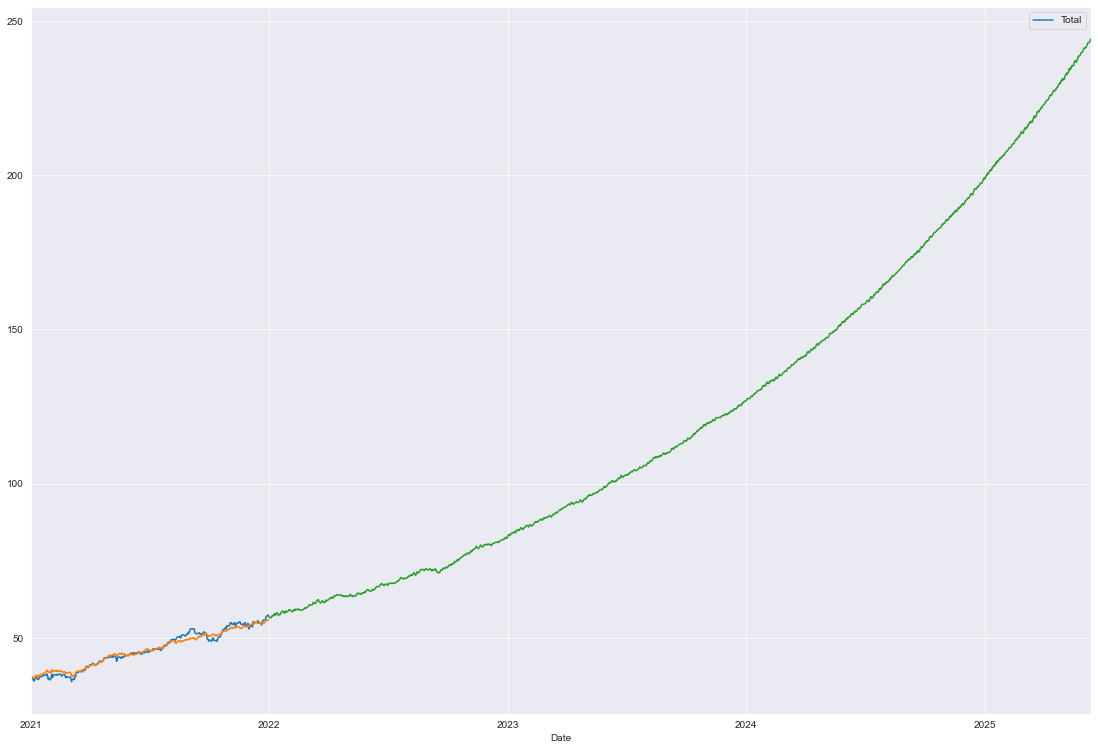

In [73]:
# Set style for seaborn plot
sns.set_style('darkgrid')
# Add automatic datetime converters
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc('figure',figsize=(19, 13))

# Set fig and ax
fig, ax = plt.subplots()

# Figure out optimum lags for this data set
lags = ar_select_order(tot_port_df, maxlag=30)
print("Lags :", lags.ar_lags)

# Create our model using whole data set
model = AutoReg(tot_port_df['Total'], lags.ar_lags)
model_fit = model.fit()

# Define training and testing area
print("Observations :", len(tot_port_df)) # 1095 observations

train_df = tot_port_df.iloc[0:1459] # First 80% 
test_df = tot_port_df.iloc[1459:] # Last 20%

# Define training model for 459 days (Play with Number & Test)
# and White's covariance estimator
train_model = AutoReg(tot_port_df['Total'], 459).fit(cov_type="HC0")

# # Define start and end for prediction 
start = len(train_df)
end = len(train_df) + len(test_df) - 1

prediction = train_model.predict(start=start, end=end, dynamic=True)

# Plot testing data with prediction
ax = test_df.plot(ax=ax) # blue
ax = prediction.plot(ax=ax) # orange

# Predict 60 days into the future
forecast = train_model.predict(start=end, end=end+1260, dynamic=True)
ax = forecast.plot(ax=ax) # Green

## Calculate annualized returns for forecasted

In [74]:
forecast

2021-12-31     57.048842
2022-01-01     56.816064
2022-01-02     56.508510
2022-01-03     56.425920
2022-01-04     56.805536
                 ...    
2025-06-09    242.905851
2025-06-10    243.157034
2025-06-11    243.361431
2025-06-12    244.066204
2025-06-13    244.052663
Freq: D, Length: 1261, dtype: float64

In [75]:
forecast_df = pd.DataFrame(forecast)

In [76]:
forecast_df

,0
2021-12-31,57.048842
2022-01-01,56.816064
2022-01-02,56.508510
2022-01-03,56.425920
2022-01-04,56.805536
...,...
2025-06-09,242.905851
2025-06-10,243.157034
2025-06-11,243.361431
2025-06-12,244.066204


In [77]:
return_series = (1 + forecast_df.pct_change()).cumprod() - 1

In [78]:
return_series

,0
2021-12-31,NaN
2022-01-01,-0.004080
2022-01-02,-0.009471
2022-01-03,-0.010919
2022-01-04,-0.004265
...,...
2025-06-09,3.257858
2025-06-10,3.262261
2025-06-11,3.265843
2025-06-12,3.278197


In [79]:
#calculate annualized return
total_return = return_series.tail(1)

annualized_return = ((1 + total_return)**(1/5))-1

print(annualized_return*100)

                    0
2025-06-13  33.735696
